# Animation of selected DMD modes

In [1]:
from os import makedirs
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from flowtorch.analysis import DMD
from utils import add_stl_patch, normalize_frequency
from flow_conditions import CHORD, A_INF, U_INF

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

data = "./output/naca0012_data/"
output = "./output/naca0012_analysis/slice/"
makedirs(output, exist_ok=True)

In [2]:
times = pt.load(f"{data}slice/times_ref1_z25.pt")
x = pt.load(f"{data}slice/x_ref1_z25.pt") / CHORD
y = pt.load(f"{data}slice/y_ref1_z25.pt") / CHORD
w = pt.load(f"{data}slice/w_ref1_z25.pt").sqrt().unsqueeze(-1)
n_points = w.shape[0]
n_times = times.shape[0]

dm = pt.zeros((3*n_points, times.shape[0]))
dm_full = pt.load(f"{data}slice/dm_ref1_z25.pt")
dm[:2*n_points, :] = dm_full[:2*n_points, :] * w.repeat((2, 1))
kappa = pt.tensor(1.4)
scale = pt.sqrt(2.0 / (kappa * (kappa - 1.0)))
U = (dm_full[:n_points, :]**2 + dm_full[n_points:2*n_points, :]**2 + dm_full[2*n_points:3*n_points, :]**2).sqrt()
Ma = dm_full[4*n_points:, :]
dm[2*n_points:, :] = scale * (U / Ma) * w
del dm_full

In [79]:
dt = times[1] - times[0]
dmd = DMD(dm, dt, optimal=True)

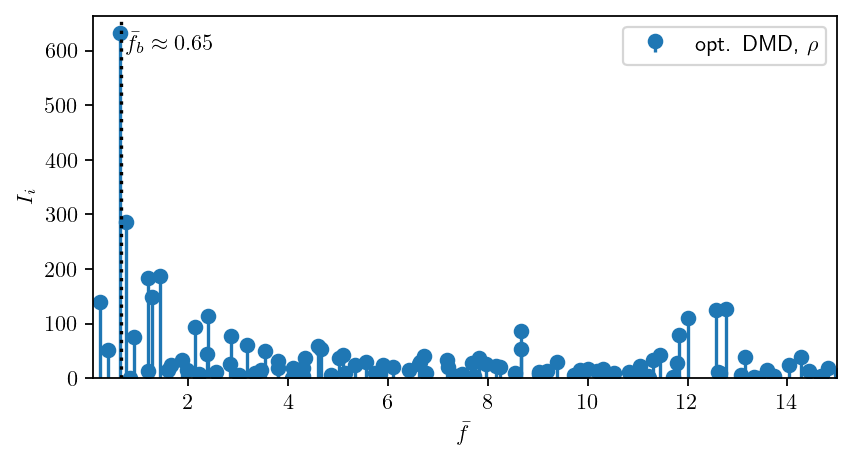

In [31]:
fb = 0.65173183

pos = dmd.frequency > 1
upos = udmd.frequency > 1

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.stem(normalize_frequency(dmd.frequency[pos].numpy()), imp[pos].numpy(), basefmt="none", linefmt="C0-", markerfmt="C0o", label=r"opt. DMD, $\rho$")
ax.set_xlabel(r"$\bar{f}$")
ax.set_ylabel(r"$I_i$")
ax.legend()
ax.set_xlim(0.1, 15)
ax.set_ylim(0)
ax.axvline(fb, ls=":", c="k")
ax.text(0.75, 600, r"$\bar{{f}}_{b}\approx 0.65$")

plt.show()

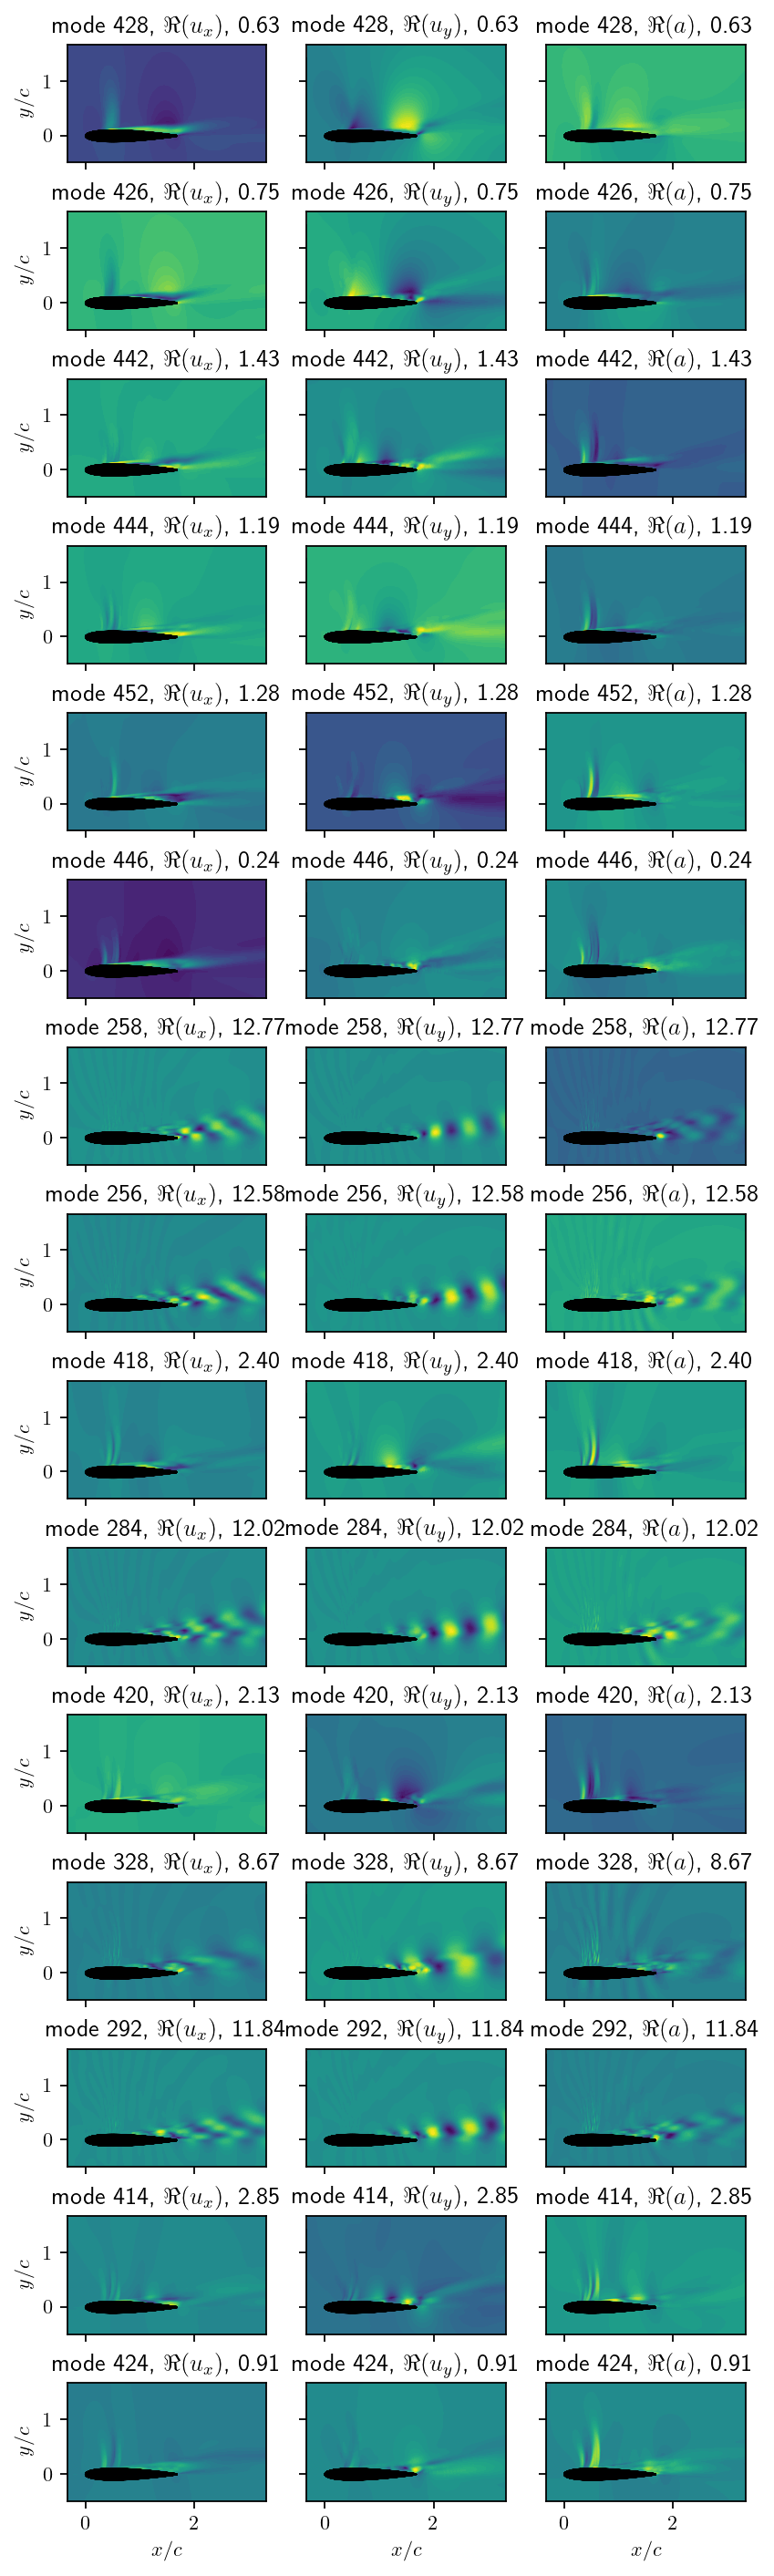

In [28]:
n_modes = 60
top = dmd.top_modes(n_modes, integral=True)
top = [mi for mi in top if dmd.frequency[mi] > 1]

n_plot = 15
fig, axarr = plt.subplots(n_plot, 3, figsize=(6, 1.5*n_plot), sharex=True, sharey=True)

for i, mi in enumerate(top[:n_plot]):
    axarr[i, 0].tricontourf(x, y, dmd.modes[:n_points, mi].real/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 1].tricontourf(x, y, dmd.modes[n_points:2*n_points, mi].imag/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 2].tricontourf(x, y, dmd.modes[2*n_points:, mi].imag/w.squeeze(), levels=50, cmap="viridis")
    axarr[i, 0].set_title(f"mode {mi}" + r", $\Re (u_x)$" + f", {normalize_frequency(dmd.frequency[mi]):2.2f}")
    axarr[i, 1].set_title(f"mode {mi}" + r", $\Re (u_y)$" + f", {normalize_frequency(dmd.frequency[mi]):2.2f}")
    axarr[i, 2].set_title(f"mode {mi}" + r", $\Re (a)$" + f", {normalize_frequency(dmd.frequency[mi]):2.2f}")
    for ax in axarr[i, :]:
        add_stl_patch(ax, scale=1.0/CHORD)
        ax.set_aspect("equal")
        ax.set_xlim(-0.2/CHORD, 2.0/CHORD)
        ax.set_ylim(-0.3/CHORD, 1.0/CHORD)

for ax in axarr[:, 0]:
    ax.set_ylabel(r"$y/c$")
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$x/c$")

plt.show()

In [67]:
bmode = dmd.top_modes(1, integral=True)[0]
bmode

tensor(389)

In [96]:
def animate_reconstruction(reconstruction, title, n_frames):
    vmin, vmax = reconstruction.min(), reconstruction.max()
    fig, ax = plt.subplots(figsize=(7, 4), dpi=640)
    plt.subplots_adjust(bottom=0.2, top=0.85, left=0.1, right=0.95)
    def animate(i):
        print("\r", f"frame {i:03d}", end="")
        ax.clear()
        tri = ax.tricontourf(x, y, reconstruction[:, i], levels=60, cmap="seismic", vmin=vmin*1.0/0.98, vmax=vmax*0.98)
        add_stl_patch(ax, scale=1.0/CHORD)
        ax.set_aspect("equal")
        ax.set_xlabel(r"$x/c$")
        ax.set_ylabel(r"$y/c$")
        ax.set_title(title)
        ax.set_xlim(-0.2, 2.0)
        ax.set_ylim(-0.3, 1.0)
    return FuncAnimation(fig, animate,  frames=n_frames, repeat=True)

In [80]:
# select dominant modes with vortex shedding
top = dmd.top_modes(50, integral=True)
top = [mi.item() for mi in top if 11 < normalize_frequency(dmd.frequency[mi]) < 14]
top

[258, 256, 284, 292, 290]

In [88]:
# add conjugate complex pair for reconstruction
vmodes = []
for mi in top:
    top2 = (dmd.frequency.abs() - dmd.frequency[mi]).abs().topk(2, largest=False).indices
    vmodes.extend(top2)
vmodes

[tensor(259),
 tensor(258),
 tensor(257),
 tensor(256),
 tensor(285),
 tensor(284),
 tensor(293),
 tensor(292),
 tensor(291),
 tensor(290)]

In [84]:
# compute mean frequency
vf = [normalize_frequency(dmd.frequency[i].abs()) for i in vmodes]
f_mean = sum(vf) / len(vf)
f_mean

tensor(12.1288)

In [89]:
# add background modes
vmodes.append(bmode)

In [91]:
# rescale eigenvalues for animation; this introduces a small error, which is acceptable for post-processing the most dominant modes
dmd._eigvals /= dmd.eigvals.abs()

In [98]:
writer = FFMpegWriter(fps=15, bitrate=1800)
anim = animate_reconstruction(dmd.partial_reconstruction({*vmodes})[2*n_points:, :300:2]/w, r"$\bar{{f}}\approx{:2.2f}$, $a$".format(f_mean), times[:300:2].shape[0])
plt.close()
anim.save(f"{output}dmd_vortex_mode_a_15fps.mp4", writer=writer)

 frame 149